In [ ]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
@njit
def calc_psi_B_jit(w, g, h, sgnB):
    psi0 = - ((w[0] + 1)/2)**3/g*((w[0] - 1)/h[0] - g*sgnB)
    return psi0

@njit
def K_jit(w, T):
    k = np.empty(w.shape[0] + 1)
    k[0] = (1 + w[0])/2
    k[-1] = (T + w[-1])/2
    k[1:-1] = (w[:-1] + w[1:])/2
    if np.any(k < 0):
        return np.zeros(w.shape[0] + 1)
    return np.power(k,3)

@njit
def dK_jit(w, k):
    dk = 3/2*np.power(k,2/3)
    return dk

@njit
def make_A_jit(w, xi, h, k, a, b):
    A = (np.diag(1 + b/(h[1:] + h[:-1])*(k[1:]/h[1:] + k[:-1]/h[:-1])) + 
         np.diag(-a/(h[1:-1] + h[:-2])*xi[:-1] - b*k[1:-1]/(h[1:-1] + h[:-2])/h[1:-1], 1) + 
         np.diag(a/(h[1:-1] + h[2:])*xi[1:] - b*k[1:-1]/(h[1:-1] + h[2:])/h[1:-1], -1))
    return A

@njit
def make_f_B_jit(w, xi, h, k, a, b, c, T, L, leakoff_array, v, tau, g):
    f = np.empty_like(w)
    f[0] = (a*xi[0]*(w[1] - 1)/(h[0] + h[1]) + 
            b*(k[1]*(w[1] - w[0])/h[1] - k[0]*(w[0] - 1)/h[0])/(h[0] + h[1]) + 
            c*(k[0] - k[1])/(h[0] + h[1])) - leakoff_array[0]
    f[1:-1] = (a*xi[1:-1]*(w[2:] - w[:-2])/(h[1:-2] + h[2:-1]) + 
               b/(h[1:-2] + h[2:-1])*(k[2:-1]*(w[2:] - w[1:-1])/h[2:-1] - k[1:-2]*(w[1:-1] - w[:-2])/h[1:-2]) + 
               c*(k[1:-2] - k[2:-1])/(h[1:-2] + h[2:-1])) - leakoff_array[1:-1]
    f[-1] = (a*xi[-1]*(T - w[-2])/(h[-1] + h[-2]) + 
             b/(h[-1] + h[-2])*(k[-1]*(T - w[-1])/h[-1] - k[-2]*(w[-1] - w[-2])/h[-2]) + 
             c*(k[-2] - k[-1])/(h[-1] + h[-2])) - L * np.sqrt(v / g / h[-1]) * tau
    return f

@njit
def make_F_B_jit(A, w, dw, xi, h, k, a, b, c, T):
    dk = dK_jit(w, k)
    # main diagonal
    F0 = np.empty_like(w)
    F0[0] = (A[0,0] + dw[0]*b/(h[0] + h[1])*(dk[1]/h[1] + dk[0]/h[0]) - 
             dw[1]*b/(h[0] + h[1])*dk[1]/h[1] - 
             b/(h[0] + h[1])*(dk[1]*(w[1] - w[0])/h[1] - dk[0]*(w[0] - 1)/h[0]) - 
             c/(h[0] + h[1])*(dk[0] - dk[1]))
    F0[1:-1] = (np.diag(A)[1:-1] - dw[2:]*b/(h[2:-1] + h[1:-2])*dk[2:-1]/h[2:-1] + 
                dw[1:-1]*b/(h[2:-1] + h[1:-2])*(dk[2:-1]/h[2:-1] + dk[1:-2]/h[1:-2]) - 
                dw[:-2]*b/(h[2:-1] + h[1:-2])*dk[1:-2]/h[1:-2] - 
                b/(h[2:-1] + h[1:-2])*(dk[2:-1]/h[2:-1]*(w[2:] - w[1:-1]) - 
                                       dk[1:-2]/h[1:-2]*(w[1:-1] - w[:-2])) - 
                c/(h[2:-1] + h[1:-2])*(dk[1:-2] - dk[2:-1]))
    F0[-1] = (A[-1,-1] - dw[-2]*b/(h[-1] + h[-2])*dk[-2]/h[-2] + 
              dw[-1]*b/(h[-1] + h[-2])*(dk[-1]/h[-1] + dk[-2]/h[-2]) - 
              b/(h[-1] + h[-2])*(-dk[-1]/h[-1]*(w[-1] - T) - dk[-2]/h[-2]*(w[-1] - w[-2])) - 
              c/(h[-1] + h[-2])*(dk[-2] - dk[-1]))
    
    # upper diagonal
    F1 = (np.diag(A, 1) - b/(h[1:-1] + h[:-2])*dk[1:-1]/h[1:-1]*dw[1:] + 
          b/(h[1:-1] + h[:-2])*dk[1:-1]/h[1:-1]*dw[:-1] - 
          b/(h[1:-1] + h[:-2])*dk[1:-1]/h[1:-1]*(w[1:] - w[:-1]) + 
          c/(h[1:-1] + h[:-2])*dk[1:-1])
    
    #lower diagonal
    F2 = (np.diag(A, -1) + dw[1:]*b/(h[1:-1] + h[2:])*dk[1:-1]/h[1:-1] - 
          dw[:-1]*b/(h[1:-1] + h[2:])*dk[1:-1]/h[1:-1] + 
          b/(h[1:-1] + h[2:])*(w[1:] - w[:-1])*dk[1:-1]/h[1:-1] - 
          c/(h[1:-1] + h[2:])*dk[1:-1])
    
    F = np.diag(F0) + np.diag(F1, 1) + np.diag(F2, -1)
    return F.astype(np.float64)

@njit
def calc_leakoff(g, t, xi, L):
    g_prev = g[-1]
    t0 = np.interp(g_prev * xi, g, t)
    # print(t0)
    # print(t[-1] - t0)
    # print(t[-2] - t0)
    if len(t) == 1:
        return np.zeros(len(xi))
    dift2 = t[-2] - t0
    dift2[dift2 < 0] = 0
    # print('dt2', dift2)
    # print('dt1', )
    return L * (np.sqrt(t[-1] - t0) - np.sqrt(dift2))

@njit
def get_solution_B_jit(t, N, xi, h, v_prev, g_prev, psi_prev, W_prev, sgnB, T, L):
    taus = t[1:] - t[:-1]
    gs = np.array([g_prev], dtype = np.float64)
    psis = np.array([psi_prev], dtype = np.float64)
    Ws = np.copy(W_prev)
    dW_tip = np.array([0], dtype = np.float64)
    vs = np.array([v_prev])
    
    for i, tau in enumerate(taus):
        steps = 0
        max_iter = 1000
        dW_prev = np.zeros(N-1, dtype = np.float64)
        err = 1
        err_psi = 10
        err_v = 100

        a = tau*v_prev/g_prev
        b = 2*tau/g_prev**2
        c = 2*tau/g_prev*sgnB

        leakoff_array = calc_leakoff(gs, t[:i + 1], xi, L)
        # print(leakoff_array)
        to_break = 0
        
        while err > 10**(-5) and err_psi > 10**(-5) and err_v > 10**(-3):         # solving nonlinear equation for given time step
            k = K_jit(W_prev + dW_prev, T)
            if np.all(k == 0):
                print('a: ', a, ', b: ', b)
                print('tau: ', tau, ', step: ', steps, ', v: ', v_prev, ', g: ', g_prev)
                print("k < 0")
                return Ws, gs, psis,vs, dW_tip
                
            A = make_A_jit(W_prev, xi, h, k, a, b)          
            f = make_f_B_jit(W_prev, xi, h, k, a, b, c, T, L, leakoff_array, v_prev, tau, g_prev)
            # print(f)
            F = make_F_B_jit(A, W_prev, dW_prev, xi, h, k, a, b, c, T)   
            # print(F)
            B = np.linalg.solve(F, A @ dW_prev - f)
            dW = dW_prev - B
            psi = calc_psi_B_jit(W_prev + dW, g_prev, h, sgnB)

            if T == 0:
                v = (W_prev[-1] + dW[-1])**2/g_prev/4*((W_prev[-1] + dW[-1])/h[-1] + g_prev*sgnB)
            else:
                v = - W_prev[-1]**2/g_prev*((T-W_prev[-2])/(h[-1]+h[-2])-g_prev*sgnB)
            
            err = np.sqrt(np.power(dW - dW_prev,2).mean())
            err_v = np.abs((v - v_prev)/v)
            err_psi = np.abs(psi - psi_prev)/psi_prev
            
            # if err > 1 or err_psi > 200 or err_v > 40000:
            #     print('error > 1')
            #     print(err, err_psi, err_v)
            #     to_break = 1
            #     break
            dW_prev = np.copy(dW)
            psi_prev = psi
            v_prev = v
            
            steps += 1
            if steps == max_iter:
                print(err, len(gs))
                print(steps, 'maxiter')
                print(W_prev)
                print(dW_prev)
                print(gs)
                to_break = 1
                break
                
        if to_break == 1:
            return Ws, gs, psis, vs, dW_tip
        dW_tip = np.append(dW_tip, dW[-1])
        W_prev = W_prev + dW
        g_prev = g_prev + v_prev*tau
        gs = np.append(gs, g_prev)
        psis = np.append(psis, psi)
        Ws = np.append(Ws, W_prev)
        vs = np.append(vs, v_prev)
    return Ws, gs, psis, vs, dW_tip

In [ ]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
N = 100
sgnB = -1
T = 0.6
L = 0

t = np.concatenate((np.logspace(-5, 2, 6001), np.linspace(100, 1000, 6001)[1:]))

xi = np.cos(np.pi / (N+1) * (np.arange(1, N + 2) - 0.5)).astype(np.float64)
xi[0], xi[-1] = 1, -1
xi = xi[::-1] * 0.5 + 0.5

if T == 0:
    xi = xi[1:-1]
    g0, W0, v0, Q0 = analyt_sol(t[0], xi)
else:
    g0, W0, v0, Q0 = analyt_sol(t[0], xi)
    W0 = get_init_solution(xi, T)[1:-1]
    xi = xi[1:-1]

h = np.zeros(N).astype(np.float64)
h[1:-1] = xi[1:] - xi[:-1]
h[0] = xi[0]
h[-1] = 1 - xi[-1]

W, g, psi, v, dw_tip = get_solution_B_jit(t, N, xi, h, v0, g0, Q0, W0, sgnB, T, L)

In [ ]:
solution = {'opening': W.reshape(len(t), len(xi)), 'length': g, 'flux': psi, 'time': t, 'x': xi}

#### Save solutions

In [55]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
with open('solution_B0_L001.pkl', 'wb') as f:
    pickle.dump(solution, f)

In [108]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
with open('solution_B1_L01.pkl', 'wb') as f:
    pickle.dump(solution, f)

In [72]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
with open('solution_B-1_L001.pkl', 'wb') as f:
    pickle.dump(solution, f)

#### Load results

In [1]:
with open('solution_B0.pkl', 'rb') as f:
    sol0 = pickle.load(f)
with open('solution_B1.pkl', 'rb') as f:
    sol1 = pickle.load(f)
with open('solution_B-1.pkl', 'rb') as f:
    sol1_ = pickle.load(f)

NameError: name 'pickle' is not defined

In [109]:
with open('solution_B0_T06.pkl', 'rb') as f:
    sol0T = pickle.load(f)
with open('solution_B1_T06.pkl', 'rb') as f:
    sol1T = pickle.load(f)
with open('solution_B-1_T06.pkl', 'rb') as f:
    sol1_T = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'solution_B0_T06.pkl'

In [74]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
with open('solution_B0_L001.pkl', 'rb') as f:
    sol0L = pickle.load(f)
with open('solution_B1_L001.pkl', 'rb') as f:
    sol1L = pickle.load(f)
with open('solution_B-1_L001.pkl', 'rb') as f:
    sol1_L = pickle.load(f)

Text(0, 0.5, 'Length')

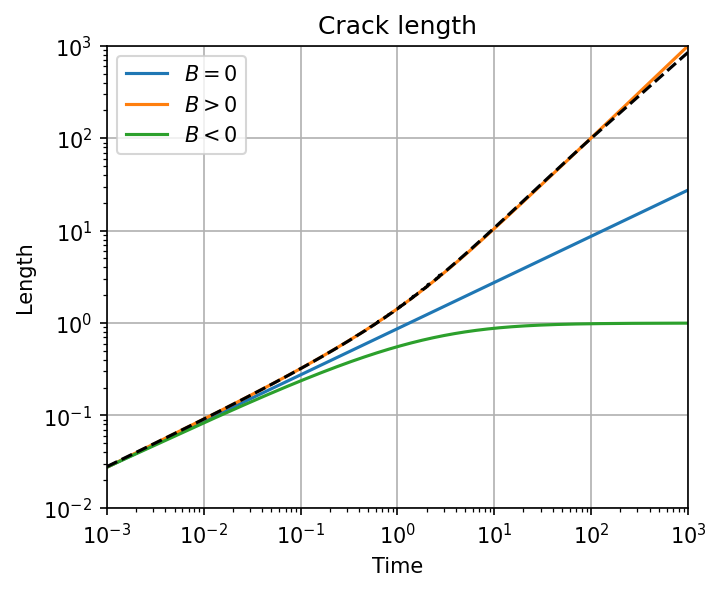

In [12]:
plt.figure(figsize = (5,4),dpi = 150)
plt.plot(sol0['time'],sol0['length'], label = '$B = 0$')
plt.plot(sol1['time'],sol1['length'], label = '$B > 0$')
plt.plot(sol1_['time'],sol1_['length'], label = '$B < 0$')
plt.plot(solution['time'], solution['length'], '--', color = "black")
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**(-3), 10**3])
plt.ylim([10**(-2), 10**3])
plt.legend()
plt.title('Crack length')
plt.xlabel('Time')
plt.ylabel('Length')

Text(0, 0.5, 'Flux')

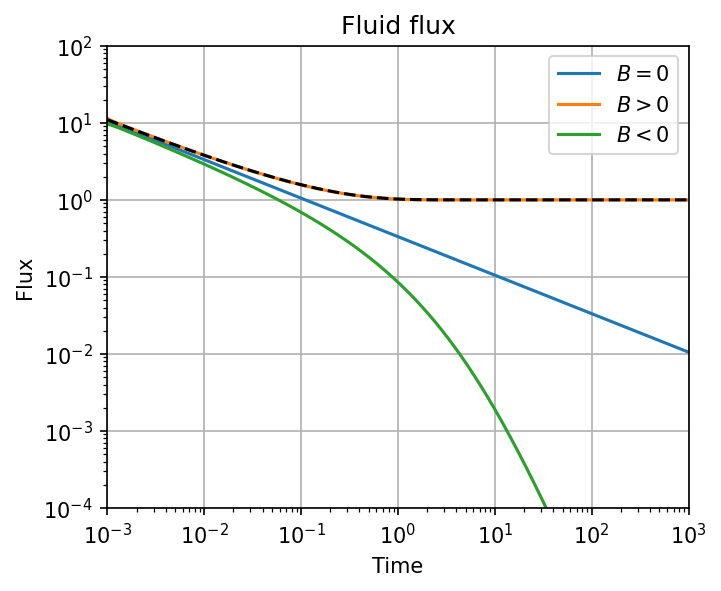

In [13]:
plt.figure(figsize = (5,4),dpi = 150)
plt.plot(sol0['time'],sol0['flux'], label = '$B = 0$')
plt.plot(sol1['time'],sol1['flux'], label = '$B > 0$')
plt.plot(sol1_['time'],sol1_['flux'], label = '$B < 0$')
plt.plot(solution['time'], solution['flux'], '--', color = "black")
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**(-3), 10**3])
plt.ylim([10**(-4), 10**2])
plt.legend()
plt.title('Fluid flux')
plt.xlabel('Time')
plt.ylabel('Flux')

In [ ]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
plt.figure(figsize = (5,4),dpi = 150)


plt.plot(sol1T['time'],sol1T['length'], label = '$B > 0$')
plt.plot(sol0T['time'],sol0T['length'], label = '$B = 0$')
plt.plot(sol1_T['time'],sol1_T['length'], label = '$B < 0$')

plt.plot(sol0['time'][:500],sol0['length'][:500], '--k')
plt.plot(sol0['time'][3500:],sol0['length'][3500:], '--k')
plt.plot(sol1['time'][4500:],sol1['length'][4500:], '--k')
plt.plot(sol1_['time'][4500:],sol1_['length'][4500:], '--k')

plt.plot(solution['time'], solution['length'], '--r', linewidth = 1)

plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**(-3), 10**3])
plt.ylim([10**(-2), 10**3])
plt.legend()
plt.title('Crack length. $\Omega(1)=0.6$')
plt.xlabel('Time')
plt.ylabel('Length')

Text(0, 0.5, 'Flux')

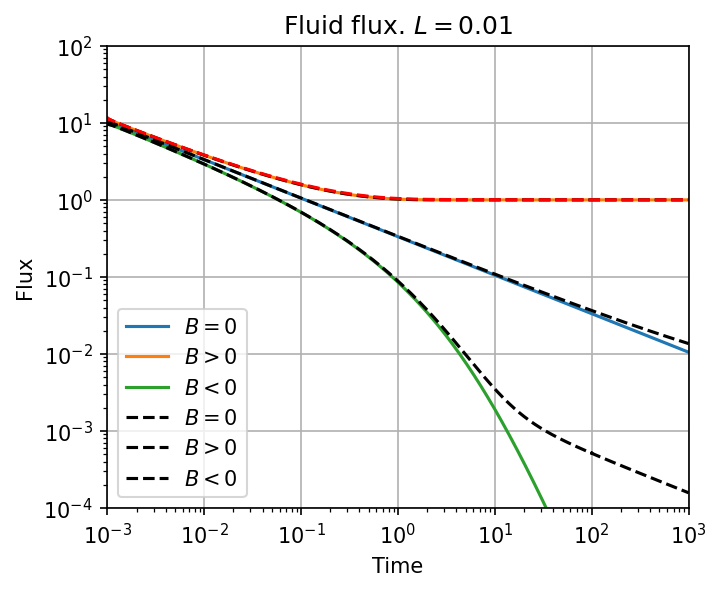

In [102]:
plt.figure(figsize = (5,4),dpi = 150)
plt.plot(sol0['time'],sol0['flux'], label = '$B = 0$')
plt.plot(sol1['time'],sol1['flux'], label = '$B > 0$')
plt.plot(sol1_['time'],sol1_['flux'], label = '$B < 0$')

plt.plot(sol0L['time'],sol0L['flux'], '--k', label = '$B = 0$')
plt.plot(sol1L['time'],sol1L['flux'], '--k', label = '$B > 0$')
plt.plot(sol1_L['time'],sol1_L['flux'], '--k', label = '$B < 0$')
plt.plot(solution['time'], solution['flux'], '--', color = "red")
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**(-3), 10**3])
plt.ylim([10**(-4), 10**2])
plt.legend()
plt.title('Fluid flux. $L = 0.01$')
plt.xlabel('Time')
plt.ylabel('Flux')

Text(0, 0.5, 'Length')

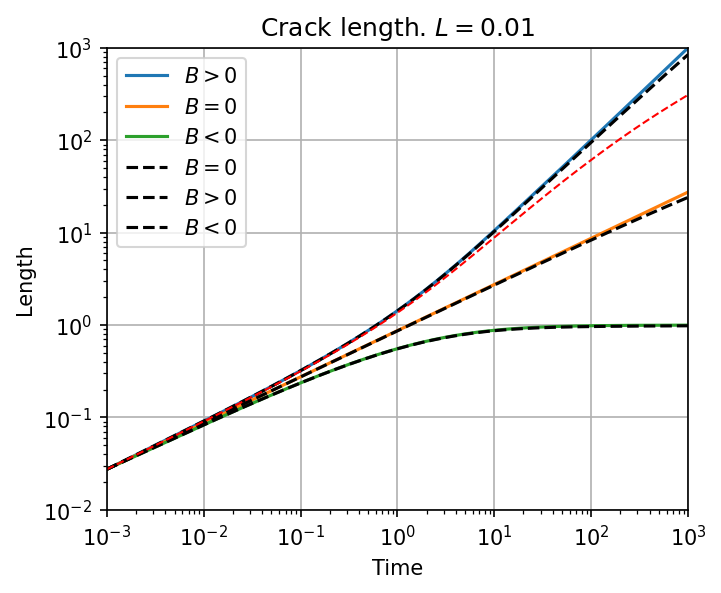

In [103]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
plt.figure(figsize = (5,4),dpi = 150)

plt.plot(sol1['time'],sol1['length'], label = '$B > 0$')
plt.plot(sol0['time'],sol0['length'], label = '$B = 0$')
plt.plot(sol1_['time'],sol1_['length'], label = '$B < 0$')

plt.plot(sol0L['time'],sol0L['length'], '--k', label = '$B = 0$')
plt.plot(sol1L['time'],sol1L['length'], '--k', label = '$B > 0$')
plt.plot(sol1_L['time'],sol1_L['length'], '--k', label = '$B < 0$')

plt.plot(solution['time'], solution['length'], '--r', linewidth = 1)

plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**(-3), 10**3])
plt.ylim([10**(-2), 10**3])
plt.legend()
plt.title('Crack length. $L = 0.01$')
plt.xlabel('Time')
plt.ylabel('Length')

Text(0, 0.5, 'Opening')

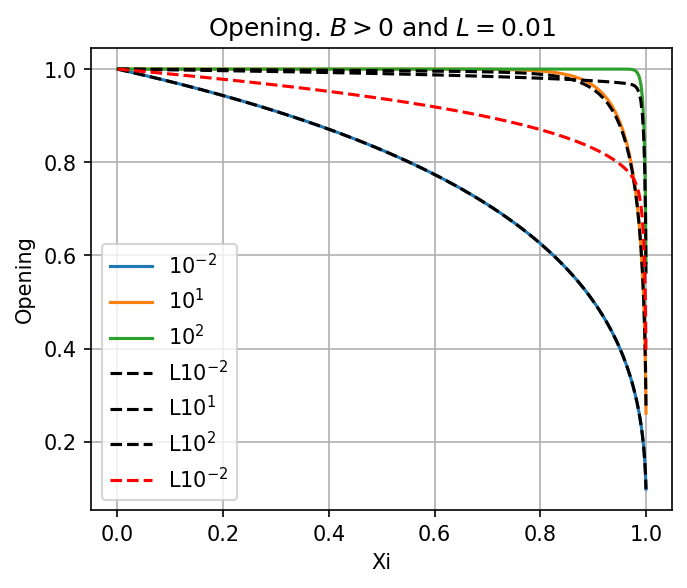

In [107]:
plt.figure(figsize = (5,4), dpi = 150)
plt.plot(sol1['x'],sol1['opening'][np.where(np.isclose(sol1['time'], 10**(-2)))][0], label = '$10^{-2}$')
plt.plot(sol1['x'],sol1['opening'][np.where(np.isclose(sol1['time'], 10**(1)))][0], label = '$10^{1}$')
plt.plot(sol1['x'],sol1['opening'][np.where(np.isclose(sol1['time'], 10**(2)))][0], label = '$10^{2}$')

plt.plot(sol1L['x'],sol1L['opening'][np.where(np.isclose(sol1L['time'], 10**(-2)))][0],"--k", label ='L$10^{-2}$')
plt.plot(sol1L['x'],sol1L['opening'][np.where(np.isclose(sol1L['time'], 10**(1)))][0],"--k", label = 'L$10^{1}$')
plt.plot(sol1L['x'],sol1L['opening'][np.where(np.isclose(sol1L['time'], 10**(2)))][0],"--k", label = 'L$10^{2}$')

plt.plot(solution['x'],solution['opening'][np.where(np.isclose(solution['time'], 10**(2)))][0],"--r", label ='L$10^{-2}$')

plt.grid()
plt.legend()
plt.title('Opening. $B>0$ and $L = 0.01$')
plt.xlabel('Xi')
plt.ylabel('Opening')

Text(0, 0.5, 'Opening')

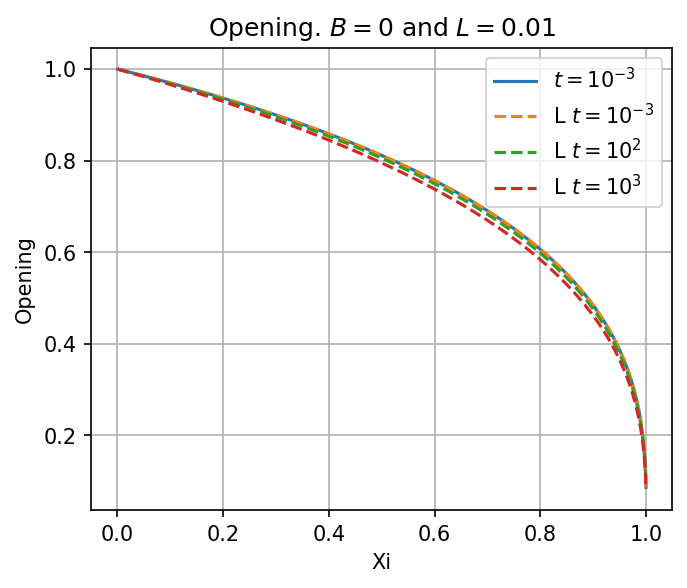

In [105]:
plt.figure(figsize = (5,4), dpi = 150)
plt.plot(sol0['x'],sol0['opening'][np.where(np.isclose(sol0['time'], 10**(-3)))][0], label = '$t = 10^{-3}$')
# plt.plot(sol0['x'],sol0['opening'][np.where(np.isclose(sol0['time'], 10**(1)))][0], label = '$10^{1}$')
# plt.plot(sol0['x'],sol0['opening'][np.where(np.isclose(sol0['time'], 10**(3)))][0], label = '$10^{2}$')

# plt.plot(solution['x'],solution['opening'][np.where(np.isclose(solution['time'], 10**(3)))][0],"--", label = 'T$10^{3}$')

plt.plot(sol0L['x'],sol0L['opening'][np.where(np.isclose(sol0L['time'], 10**(-3)))][0],'--', label ='L $t = 10^{-3}$')
plt.plot(sol0L['x'],sol0L['opening'][np.where(np.isclose(sol0L['time'], 10**(2)))][0],'--',  label ='L $t = 10^{2}$')
plt.plot(sol0L['x'],sol0L['opening'][np.where(np.isclose(sol0L['time'], 10**(3)))][0],'--',  label = 'L $t = 10^{3}$')

plt.grid()
plt.legend()
plt.title('Opening. $B=0$ and $L = 0.01$')
plt.xlabel('Xi')
plt.ylabel('Opening')

Text(0, 0.5, 'Opening')

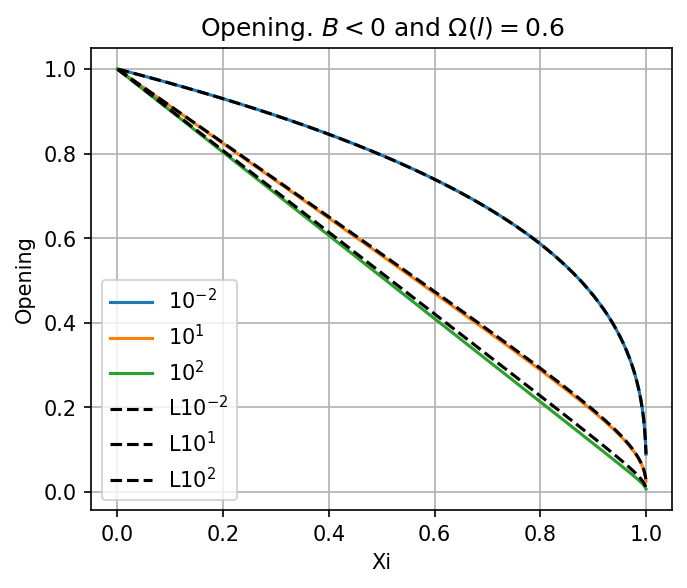

In [106]:
plt.figure(figsize = (5,4), dpi = 150)
plt.plot(sol1_['x'],sol1_['opening'][np.where(np.isclose(sol1_['time'], 10**(-2)))][0], label = '$10^{-2}$')
plt.plot(sol1_['x'],sol1_['opening'][np.where(np.isclose(sol1['time'], 10**(1)))][0], label = '$10^{1}$')
plt.plot(sol1_['x'],sol1_['opening'][np.where(np.isclose(sol1['time'], 10**(2)))][0], label = '$10^{2}$')

plt.plot(sol1_L['x'],sol1_L['opening'][np.where(np.isclose(sol1_L['time'], 10**(-2)))][0],"--", c = 'black', label = 'L$10^{-2}$')
plt.plot(sol1_L['x'],sol1_L['opening'][np.where(np.isclose(sol1_L['time'], 10**(1)))][0],"--", c = 'black', label = 'L$10^{1}$')
plt.plot(sol1_L['x'],sol1_L['opening'][np.where(np.isclose(sol1_L['time'], 10**(2)))][0],"--", c = 'black', label = 'L$10^{2}$')

plt.grid()
plt.legend()
plt.title('Opening. $B<0$ and $\Omega(l) = 0.6$')
plt.xlabel('Xi')
plt.ylabel('Opening')